# True Zonal Mean

Calculate the *true zonal mean* of a scalar quantity regardless of the horizontal mesh. 

Specifically, we calculate the volume weighted mean along all grid cells whose centres fall within finite latitude intervals rather than the arithmetic mean of cells along the model's curvilinear grid. The method presented can also be used to re-grid models onto the same latitudinal grid and the general principles can be used to define any multidimensional sum or average using the `xhistogram` package.
    
**Requirements:** 
Select the `conda/analysis3-22.04` (or later) kernel.
This code should work for just about any MOM5 configuration since all we are grabbing is temeprature and standard grid information. You can swap temperature with any other scalar variable. You can also in principle swap latitude with another scalar.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from dask.distributed import Client
from xhistogram.xarray import histogram #This package has only recently been added to conda/analysis3-20.01

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45875/status,
Dashboard: /proxy/45875/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38367,Workers: 4
Dashboard: /proxy/45875/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:34211,Total threads: 3
Dashboard: /proxy/34243/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:36995,


In [3]:
session = cc.database.create_session()

Choose the run and the variable we want to average. I am using temperature but you can choose any scalar.

In [4]:
experiment = '025deg_jra55v13_iaf_gmredi6' #Choose any run
variable = 'temp' #any scalar variable where volume weighted averaging makes sense
variable_to_average = cc.querying.getvar(experiment, variable, session, ncfile='ocean.nc')
variable_to_average

,Array,Chunk
Bytes,86.90 GiB,2.37 MiB
Shape,"(300, 50, 1080, 1440)","(1, 10, 216, 288)"
Count,75154 Tasks,37500 Chunks
Type,float32,numpy.ndarray


First we show the standard approach, which is to take the arithmetic mean of all grid cells along the quasi-longitudinal coordinate. For MOM5's tri-polar grid this approach is in principle "okay" for the southern hemisphere, where grid cell areas are constant at fixed latitude. It doesn't though, take into account partial cells.

The `xarray`'s method `.mean(dim='dimension')` applies `numpy.mean()` across that dimension. This is simply the arithmetic mean.

For some scalar $T$ the arithmetic mean, e.g., across dimension `i`, is given by

$$ \left<T\right>_{j,k} = \frac{1}{I}\sum_{i=1}^{I} T_{i,j,k},$$

where $i$, $j$ and $k$ are the indicies in the $x$, $y$ and $z$ directions respectively of the curvilinear grid and $I$ is the number of indicies along the $x$ axis. 

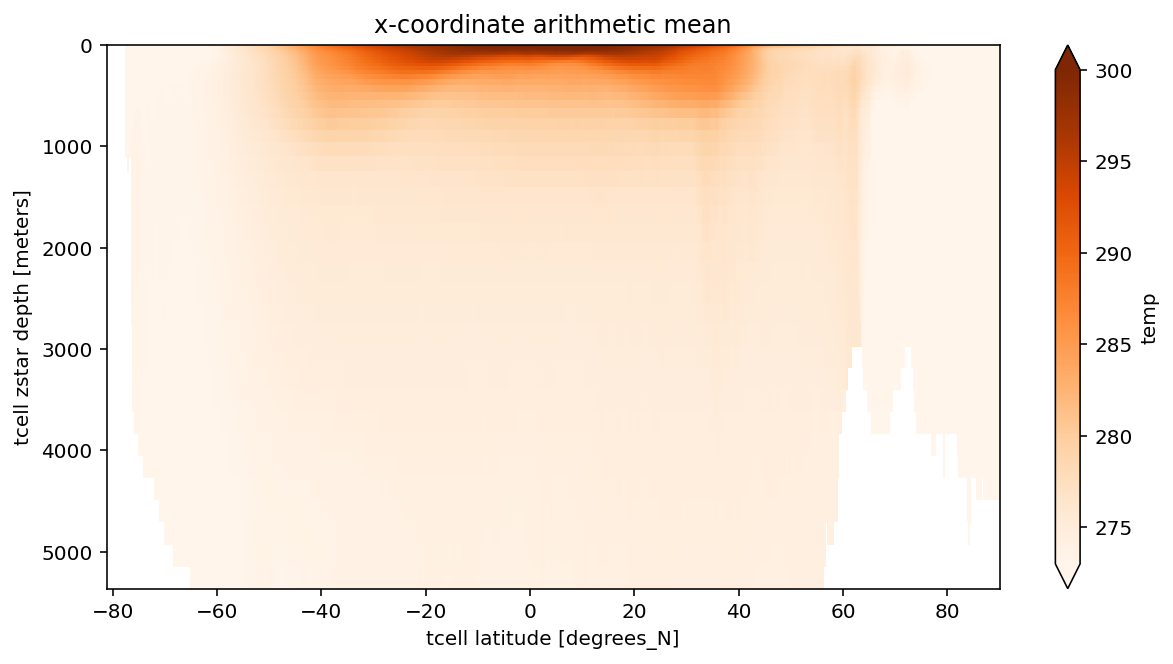

In [5]:
x_arith_mean = variable_to_average.groupby('time.year').mean(dim='time').mean(dim='xt_ocean')

plt.figure(figsize=(10, 5))
x_arith_mean.sel(year=2000).plot(yincrease=False, vmin=273, vmax=300, cmap='Oranges')
plt.title('x-coordinate arithmetic mean');

The main issue with this average is that the 'latitude' coordinate may be meaningless near the north pole, particulalrly when comparing to observational analyses or other models which can have either a regular grid or a different curvilinear grid. Even different versions of MOM might have different grids! 

Let us consider what the true zonal average looks like. That is consider a set of latitude 'edges' $\{\phi'_{1/2},\phi'_{1+1/2},...,\phi'_{\ell-1/2},\phi'_{\ell+1/2},...,\phi'_{L+1/2}\}$ between which we want to compute an average of $T$ at $\{\phi'_{1},\phi'_{2},...,\phi'_{\ell},...,\phi'_{L}\}$ such that

$$ \overline{T}(\phi'_\ell,\sigma) = \dfrac{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}} T(\phi,\lambda,\sigma)\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A}{\iint_{\phi'_{\ell-1/2} < \phi \leq \phi'_{\ell+1/2}}\frac{\partial z}{\partial \sigma}(\phi,\lambda,\sigma)\,\mathrm{d}A},$$

where $\lambda$ is longitude and $\sigma$ is an arbitrary vertical coordinate. 

In discrete form this average is

$$\overline{T}_{\ell,k} = \frac{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j}T_{i,j,k}\Delta Z_{i,j,k}\Delta \mathrm{Area}_{i,j}}{\sum_{i=1}^{I}\sum_{j=1}^{J}\delta_{i,j,k}\Delta Z_{i,j,k}\Delta \mathrm{Area}_{i,j}},$$

where $\delta_{i,j} = 1$ if $\phi'_{\ell-1/2}<\phi_{i,j}\leq \phi'_{\ell+1/2}$ and $\delta_{i,j} = 0$ elsewhere, $\Delta Z$ is the grid cell vertical thickness and $\Delta \mathrm{Area}$ is the grid cell horizontal area.

For our purposes we will use the edges of the models `xt_ocean` coordinate to define $\phi'_{\ell+1/2}$ so the number of 'bins' $L$ will be the same as the length of the quasi-latitude coordinate ($J$). 

Fortunately, as you can see below, the two sums are weighted histograms (one for $T$ times volume and the other for just volume) and these can be rapidly computed using `xhistogram`.

First lets load the scalar variable (latitude) we want to use as our coordinate then define the bin edges.

In [6]:
coord = 'geolat_t' #can be any scalar (2D, 3D, eulerian, lagrangian etc)
variable_as_coord = cc.querying.getvar(experiment, coord, session, n=1) #might need ncfile='ocean.nc' if a tracer

#Define the coordinate bins as the latitude edges of the T-cells
yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)
#make numpy array (using .values) and add 1st edge at -90
bins =  np.insert(yu_ocean.values, 0, np.array(-90), axis=0) 

#Alternatively we could just use some regular grid like this 
#coordbins =  np.linspace(-80, 90, 50)
#or use a grid from a different (coarser) model.

dzt = cc.querying.getvar(experiment, 'dzt', session, ncfile='ocean.nc') #thickness of cells
area_t = cc.querying.getvar(experiment, 'area_t', session, n=1) #area of cells

dVol = dzt * area_t #Volume of cells

Now let's compute the numerator and denominator of the equation above using `xhistogram`, then the time mean and then the zonal mean.

In [7]:
histVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins=[bins], weights=dVol, dim=['yt_ocean', 'xt_ocean'])
histTVolCoordDepth = histogram(variable_as_coord.broadcast_like(dVol).where(~np.isnan(dVol)), bins=[bins], weights=dVol * variable_to_average, dim=['yt_ocean', 'xt_ocean'])
coord_mean = (histTVolCoordDepth/histVolCoordDepth).groupby('time.year').mean(dim='time')

Now we can plot the results which thankfully retain all the data-array info on variables and axis etc.

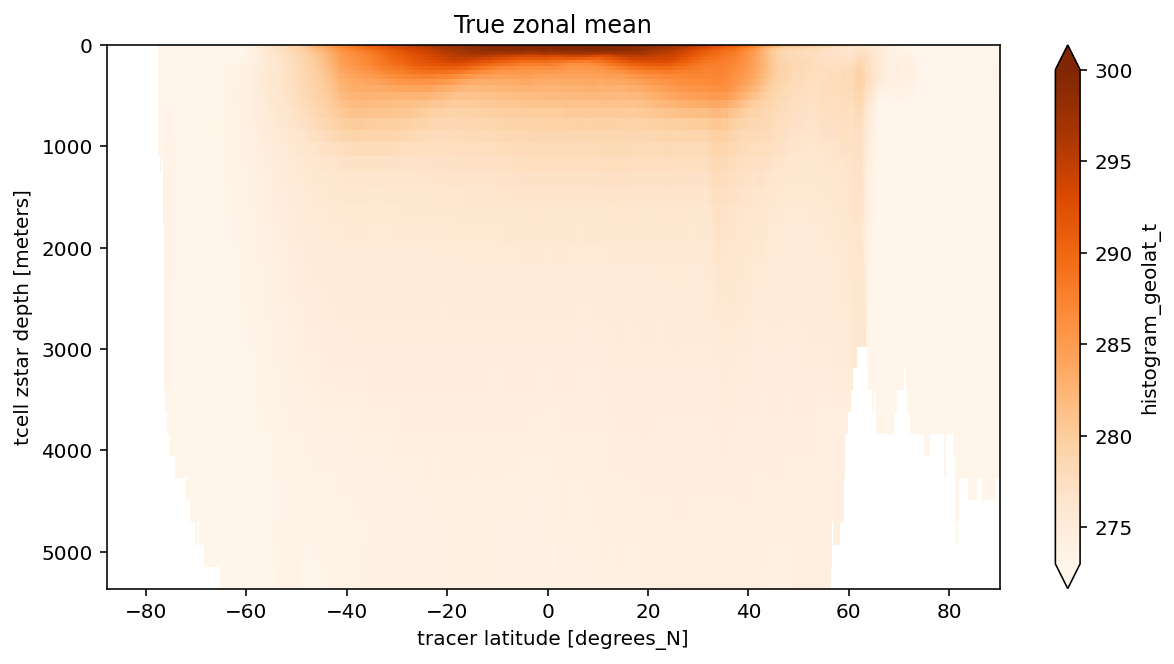

In [8]:
plt.figure(figsize=(10, 5))
coord_mean.sel(year=2000).plot(yincrease=False, vmin=273, vmax=300, cmap='Oranges')
plt.title('True zonal mean');

Since we used the same bin edges as the standard `yt_ocean` coordinate we can take a difference between the arithmetic mean along the model's x-axis and our mean along grid cells within latitude bands. The main differences are near the North Pole where the grid is furthest for being regular. There are also differences near the Antacrtic Shelf suggesting partial cells also matter.

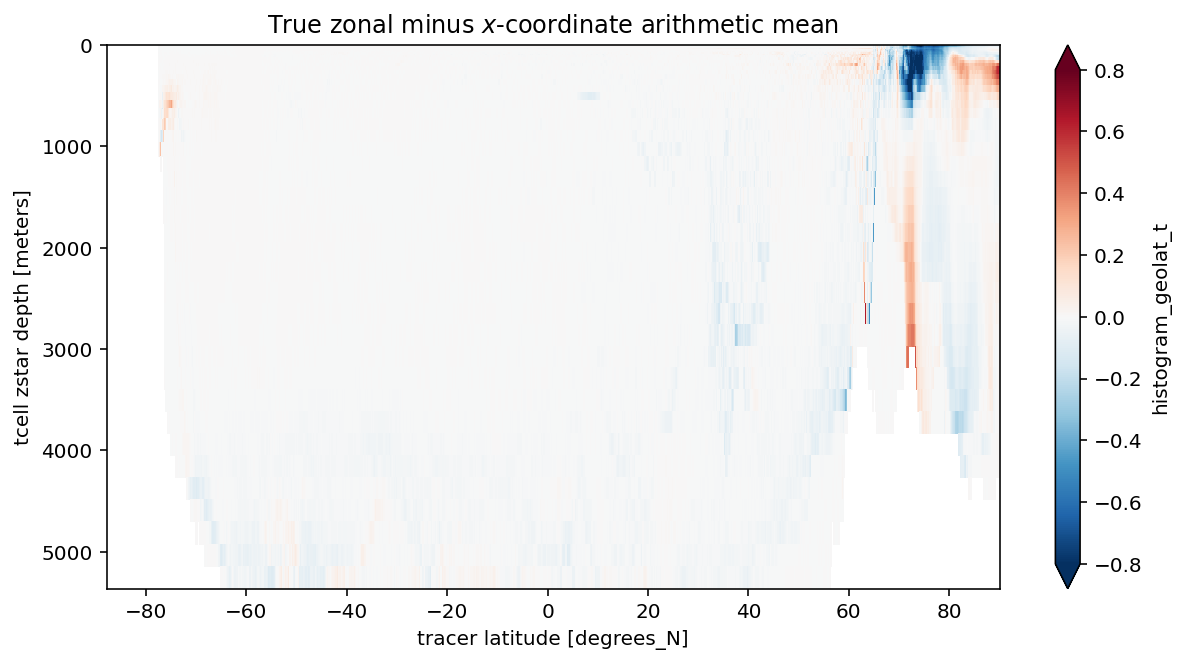

In [9]:
zonal_minus_x_mean = coord_mean.sel(year=2000) - x_arith_mean.sel(year=2000).values

plt.figure(figsize=(10, 5))
zonal_minus_x_mean.plot(yincrease=False, vmin=-0.8, vmax=0.8, cmap='RdBu_r', extend='both')
plt.title('True zonal minus $x$-coordinate arithmetic mean');

`xarray` has a new `weighted` functionality which allows it to do weighted means instead of arithmetic mean.

Let's see how that works out... We chose `dVol` as the weights and we only do the comparisson for year 2000.

In [10]:
variable_to_average_weighted = variable_to_average.copy().sel(time='2000').mean(dim='time')
variable_to_average_weighted = variable_to_average_weighted.weighted(dVol.sel(time='2000').fillna(0))
meanweighted_y2000 = variable_to_average_weighted.mean(dim='xt_ocean').groupby('time.year').mean(dim='time').sel(year=2000)

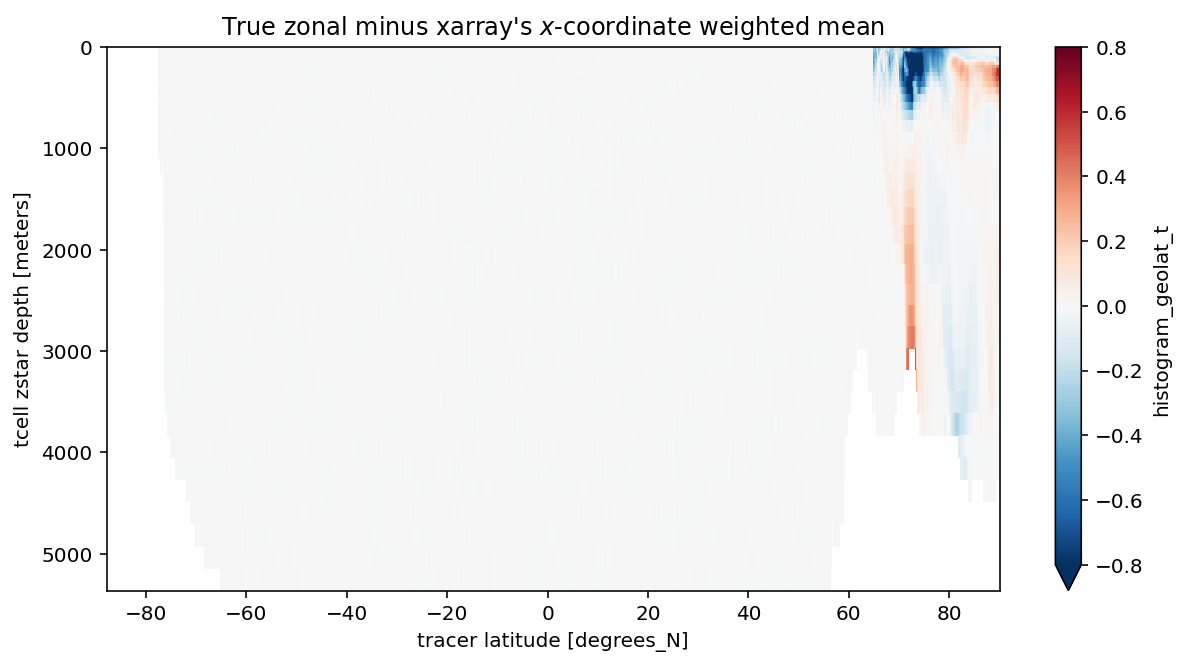

In [11]:
zonal_minus_x_mean = coord_mean.sel(year=2000) - meanweighted_y2000.values

plt.figure(figsize=(10, 5))
zonal_minus_x_mean.plot(yincrease=False, vmin=-0.8, vmax=0.8, cmap='RdBu_r')
plt.title("True zonal minus xarray's $x$-coordinate weighted mean");    

South of 65N, where complications of the tripolar grid don't matter, `xarray`'s weighted mean does the job! But in the region of the tripolar we need to be more careful.